#US Weather Events (2016-2022) Data Analysis

This Kaggle data set has a collection of weather events data spanning January 2016 to December 2022. The data includes information on type of weather (snow, rain, cold, etc.), severity of the weather, start time and end times of the weather events, time zone, and associated airport code, among others.

Link to Data: https://www.kaggle.com/datasets/sobhanmoosavi/us-weather-events/data

As part of this analysis, we will first clean and explore the data and then perform K-Means clustering to identify states with similar weather patterns based on the percentage of observations of each weather event type for each state.

##Imports and Set-Up

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import seaborn as sns
from sklearn.cluster import KMeans

##Load Data and Data Cleaning

In [2]:
# Import data
weather_df = pd.read_csv('WeatherEvents_Jan2016-Dec2022.csv')

In [3]:
weather_df.head()

,EventId,Type,Severity,StartTime(UTC),EndTime(UTC),Precipitation(in),TimeZone,AirportCode,LocationLat,LocationLng,City,County,State,ZipCode
0,W-1,Snow,Light,2016-01-06 23:14:00,2016-01-07 00:34:00,0.00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
1,W-2,Snow,Light,2016-01-07 04:14:00,2016-01-07 04:54:00,0.00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
2,W-3,Snow,Light,2016-01-07 05:54:00,2016-01-07 15:34:00,0.03,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
3,W-4,Snow,Light,2016-01-08 05:34:00,2016-01-08 05:54:00,0.00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
4,W-5,Snow,Light,2016-01-08 13:54:00,2016-01-08 15:54:00,0.00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0


In [4]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8627181 entries, 0 to 8627180
Data columns (total 14 columns):
 #   Column             Dtype  
---  ------             -----  
 0   EventId            object 
 1   Type               object 
 2   Severity           object 
 3   StartTime(UTC)     object 
 4   EndTime(UTC)       object 
 5   Precipitation(in)  float64
 6   TimeZone           object 
 7   AirportCode        object 
 8   LocationLat        float64
 9   LocationLng        float64
 10  City               object 
 11  County             object 
 12  State              object 
 13  ZipCode            float64
dtypes: float64(4), object(10)
memory usage: 921.5+ MB


In [5]:
# Check for duplicate entries
weather_df.duplicated().sum()

0

In [6]:
# Check for missing values
weather_df.isnull().sum()

EventId                  0
Type                     0
Severity                 0
StartTime(UTC)           0
EndTime(UTC)             0
Precipitation(in)        0
TimeZone                 0
AirportCode              0
LocationLat              0
LocationLng              0
City                 16912
County                   0
State                    0
ZipCode              69199
dtype: int64

In [7]:
# % of null values in ZipCode column
weather_df['ZipCode'].isnull().sum() / len(weather_df)

0.00802104418581226

In [8]:
# Drop all null values
weather_df.dropna(inplace = True)

The ZipCode column had the highest number of missing values but was just ~1.5% of the total data. Since the missing values make up a very small percentage of the data, we choose to drop the missing values.

In [9]:
weather_df.isnull().sum()

EventId              0
Type                 0
Severity             0
StartTime(UTC)       0
EndTime(UTC)         0
Precipitation(in)    0
TimeZone             0
AirportCode          0
LocationLat          0
LocationLng          0
City                 0
County               0
State                0
ZipCode              0
dtype: int64

In [10]:
weather_df.shape

(8557982, 14)

In [11]:
weather_df['Type'].value_counts()

Type
Rain             4974556
Fog              1992230
Snow             1143419
Cold              230205
Precipitation     156549
Storm              58114
Hail                2909
Name: count, dtype: int64

In [12]:
weather_df['Severity'].value_counts()

Severity
Light       5114329
Severe      1707251
Moderate    1359118
Heavy        217826
UNK          156549
Other          2909
Name: count, dtype: int64

In [13]:
# Convert start and end times to datetime
weather_df['StartTime(UTC)'] = pd.to_datetime(weather_df['StartTime(UTC)'])
weather_df['EndTime(UTC)'] = pd.to_datetime(weather_df['EndTime(UTC)'])

##Exploratory Data Analysis

In [14]:
# Count of type of weather by time zones
timezone_df = weather_df.groupby(['TimeZone', 'Type']).size().reset_index(name = 'count')
timezone_df.head(10)

,TimeZone,Type,count
0,US/Central,Cold,114472
1,US/Central,Fog,818550
2,US/Central,Hail,904
3,US/Central,Precipitation,87327
4,US/Central,Rain,2076331
5,US/Central,Snow,423209
6,US/Central,Storm,20465
7,US/Eastern,Cold,67986
8,US/Eastern,Fog,726203
9,US/Eastern,Hail,1509


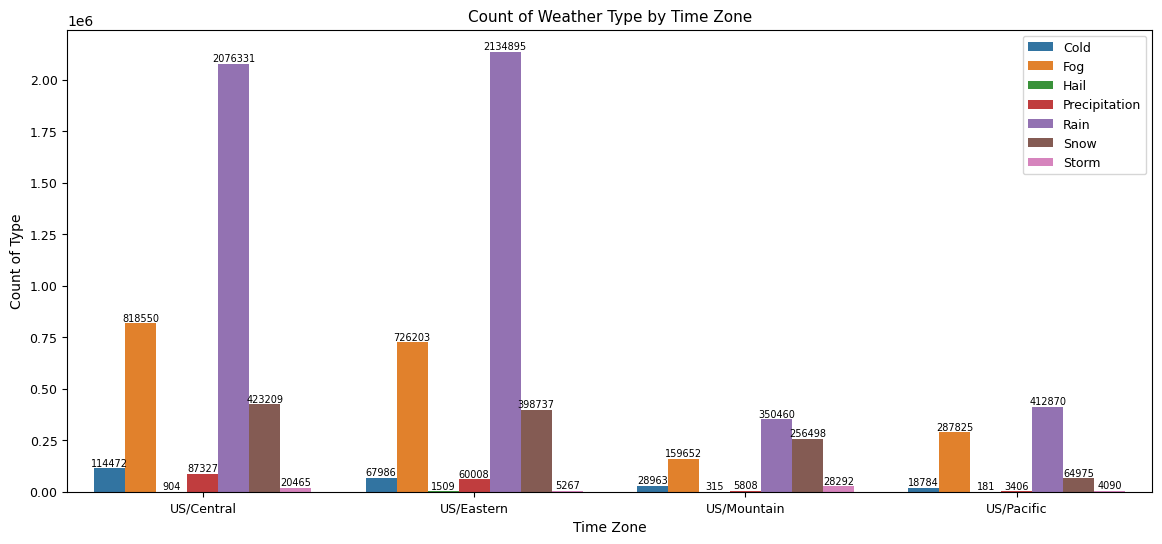

In [61]:
fig = plt.subplots(figsize = (14,6))
ax = sns.barplot(data = timezone_df, x = 'TimeZone', y = 'count', hue = 'Type')
for bars in ax.containers:
  ax.bar_label(bars, fontsize = 7, fmt = '%d')
plt.xlabel('Time Zone', fontsize = 10)
plt.ylabel('Count of Type', fontsize = 10)
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9)
plt.title('Count of Weather Type by Time Zone', fontsize = 11)
plt.grid(visible=False)
plt.legend(fontsize = 9)
plt.show()

Rain is the most common type of weather across all time zones, while hail is the least common. Precipitation is the least occurring in the Pacific time zone and storms are the most common in the Mountain time zone.

In [16]:
# Total Precipitation by State
precipitation_df = weather_df.groupby(['State'])['Precipitation(in)'].sum().reset_index()
precipitation_df.sort_values(by = 'Precipitation(in)', inplace = True, ascending = False)
precipitation_df.head()

,State,Precipitation(in)
31,NY,67824.90
40,TX,60961.29
7,FL,55894.49
24,NC,36199.71
15,LA,30586.65


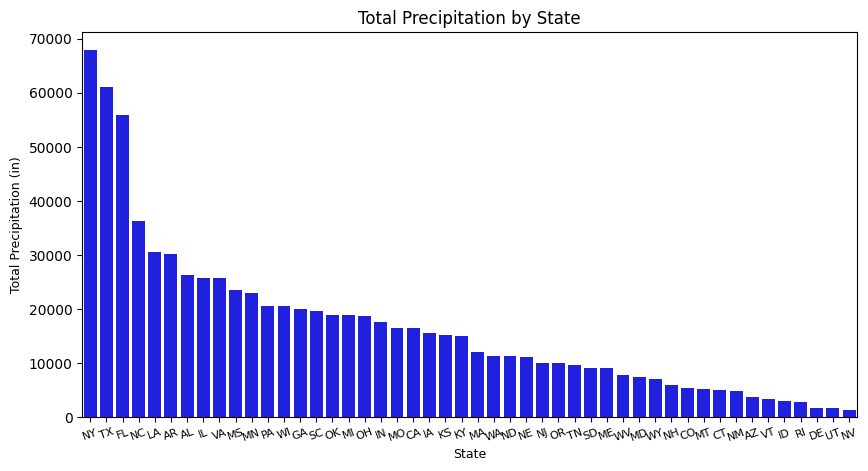

In [17]:
fig = plt.subplots(figsize = (10,5))
ax = sns.barplot(data = precipitation_df, x = 'State', y = 'Precipitation(in)', color = 'Blue')
plt.xlabel('State', fontsize = 9)
plt.ylabel('Total Precipitation (in)', fontsize = 9)
plt.xticks(fontsize = 8, rotation = 20)
plt.title('Total Precipitation by State')
plt.grid(visible=False)
plt.show()

New York, Minnesota, and Florida had the most precipitation from 2016-2022 among all the states.

##Clustering Analysis

###Round 1

In [42]:
# K-Means Clustering

weather_type_df = weather_df.copy()
weather_type_df = pd.get_dummies(weather_type_df, columns = ['Type'], prefix = '', prefix_sep = '')
weather_type_df = weather_type_df[['State', 'Cold', 'Fog', 'Hail', 'Precipitation', 'Rain', 'Snow', 'Storm']]
weather_type_df = weather_type_df.groupby('State').sum().reset_index()
weather_type_df['Total'] = weather_type_df.sum(axis = 1, numeric_only = True)

In [43]:
# Calculate % of days of weather type for each state
weather_type_df['% Cold'] = (weather_type_df['Cold'] / weather_type_df['Total']) * 100
weather_type_df['% Fog'] = (weather_type_df['Fog'] / weather_type_df['Total']) * 100
weather_type_df['% Precipitation'] = (weather_type_df['Precipitation'] / weather_type_df['Total']) * 100
weather_type_df['% Rain'] = (weather_type_df['Rain'] / weather_type_df['Total']) * 100
weather_type_df['% Snow'] = (weather_type_df['Snow'] / weather_type_df['Total']) * 100
weather_type_df['% Storm'] = (weather_type_df['Storm'] / weather_type_df['Total']) * 100
weather_type_df.head()

,State,Cold,Fog,Hail,Precipitation,Rain,Snow,Storm,Total,% Cold,% Fog,% Precipitation,% Rain,% Snow,% Storm
0,AL,5530,41534,45,6163,134788,1433,131,189624,2.916298,21.903346,3.250116,71.081720,0.755706,0.069084
1,AR,3552,39362,12,6226,105919,3683,173,158927,2.234988,24.767346,3.917522,66.646322,2.317416,0.108855
2,AZ,3850,12008,21,691,36761,8253,980,62564,6.153699,19.193146,1.104469,58.757432,13.191292,1.566396
3,CA,13749,171255,32,2106,144099,14175,2608,348024,3.950590,49.207813,0.605131,41.404903,4.072995,0.749374
4,CO,5728,31463,100,924,76664,60478,8119,183476,3.121934,17.148292,0.503608,41.784212,32.962349,4.425102


In [44]:
# Create dataframe to use for K-means clustering iteration using the percentage data calculated above
cluster_df = weather_type_df.copy()
cluster_df.drop(['State', 'Cold', 'Fog', 'Hail', 'Precipitation', 'Rain', 'Snow', 'Storm', 'Total'], inplace = True, axis = 1)
cluster_df.head()

,% Cold,% Fog,% Precipitation,% Rain,% Snow,% Storm
0,2.916298,21.903346,3.250116,71.081720,0.755706,0.069084
1,2.234988,24.767346,3.917522,66.646322,2.317416,0.108855
2,6.153699,19.193146,1.104469,58.757432,13.191292,1.566396
3,3.950590,49.207813,0.605131,41.404903,4.072995,0.749374
4,3.121934,17.148292,0.503608,41.784212,32.962349,4.425102


In order to perform K-Means clustering, we use the percentage of events of each weather type for each state.

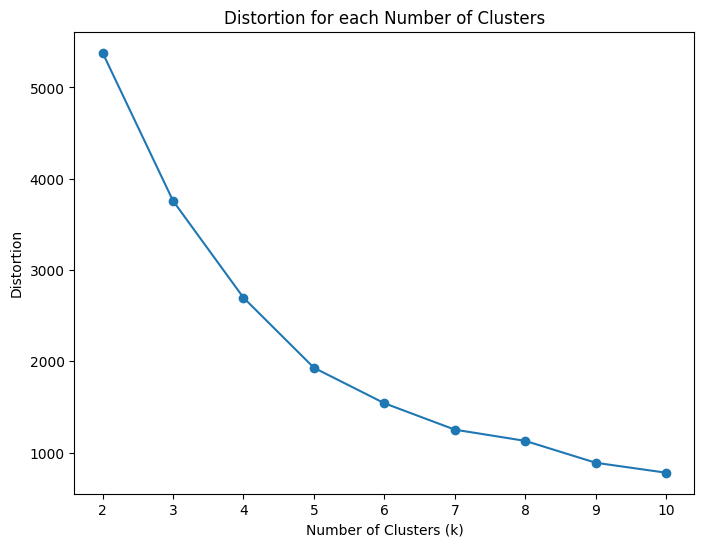

In [45]:
distortions = []

max_k = 10
for i in range (2, max_k+1):
  km = KMeans(n_clusters = i, n_init = 5, random_state = 0, max_iter = 400)
  km.fit(cluster_df)
  distortions.append(km.inertia_)

fig = plt.subplots(figsize = (8,6))
plt.plot(range(2, max_k+1), distortions, marker = 'o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('Distortion for each Number of Clusters')
plt.show()

Using the elbow method, we can see the 5 is the ideal number of clusters.

In [46]:
km = KMeans(n_clusters = 5, n_init = 5, random_state = 0, max_iter = 400)
kmeans = km.fit(cluster_df)

In [47]:
# Get cluster labels
clusters = pd.DataFrame(kmeans.labels_, columns = ['Labels'])
clusters['Labels'].value_counts()

Labels
2    17
0    16
4    11
1     3
3     1
Name: count, dtype: int64

In [48]:
weather_type_df['Cluster_Labels'] = clusters['Labels']
cluster_df['Cluster_Labels'] = clusters['Labels']

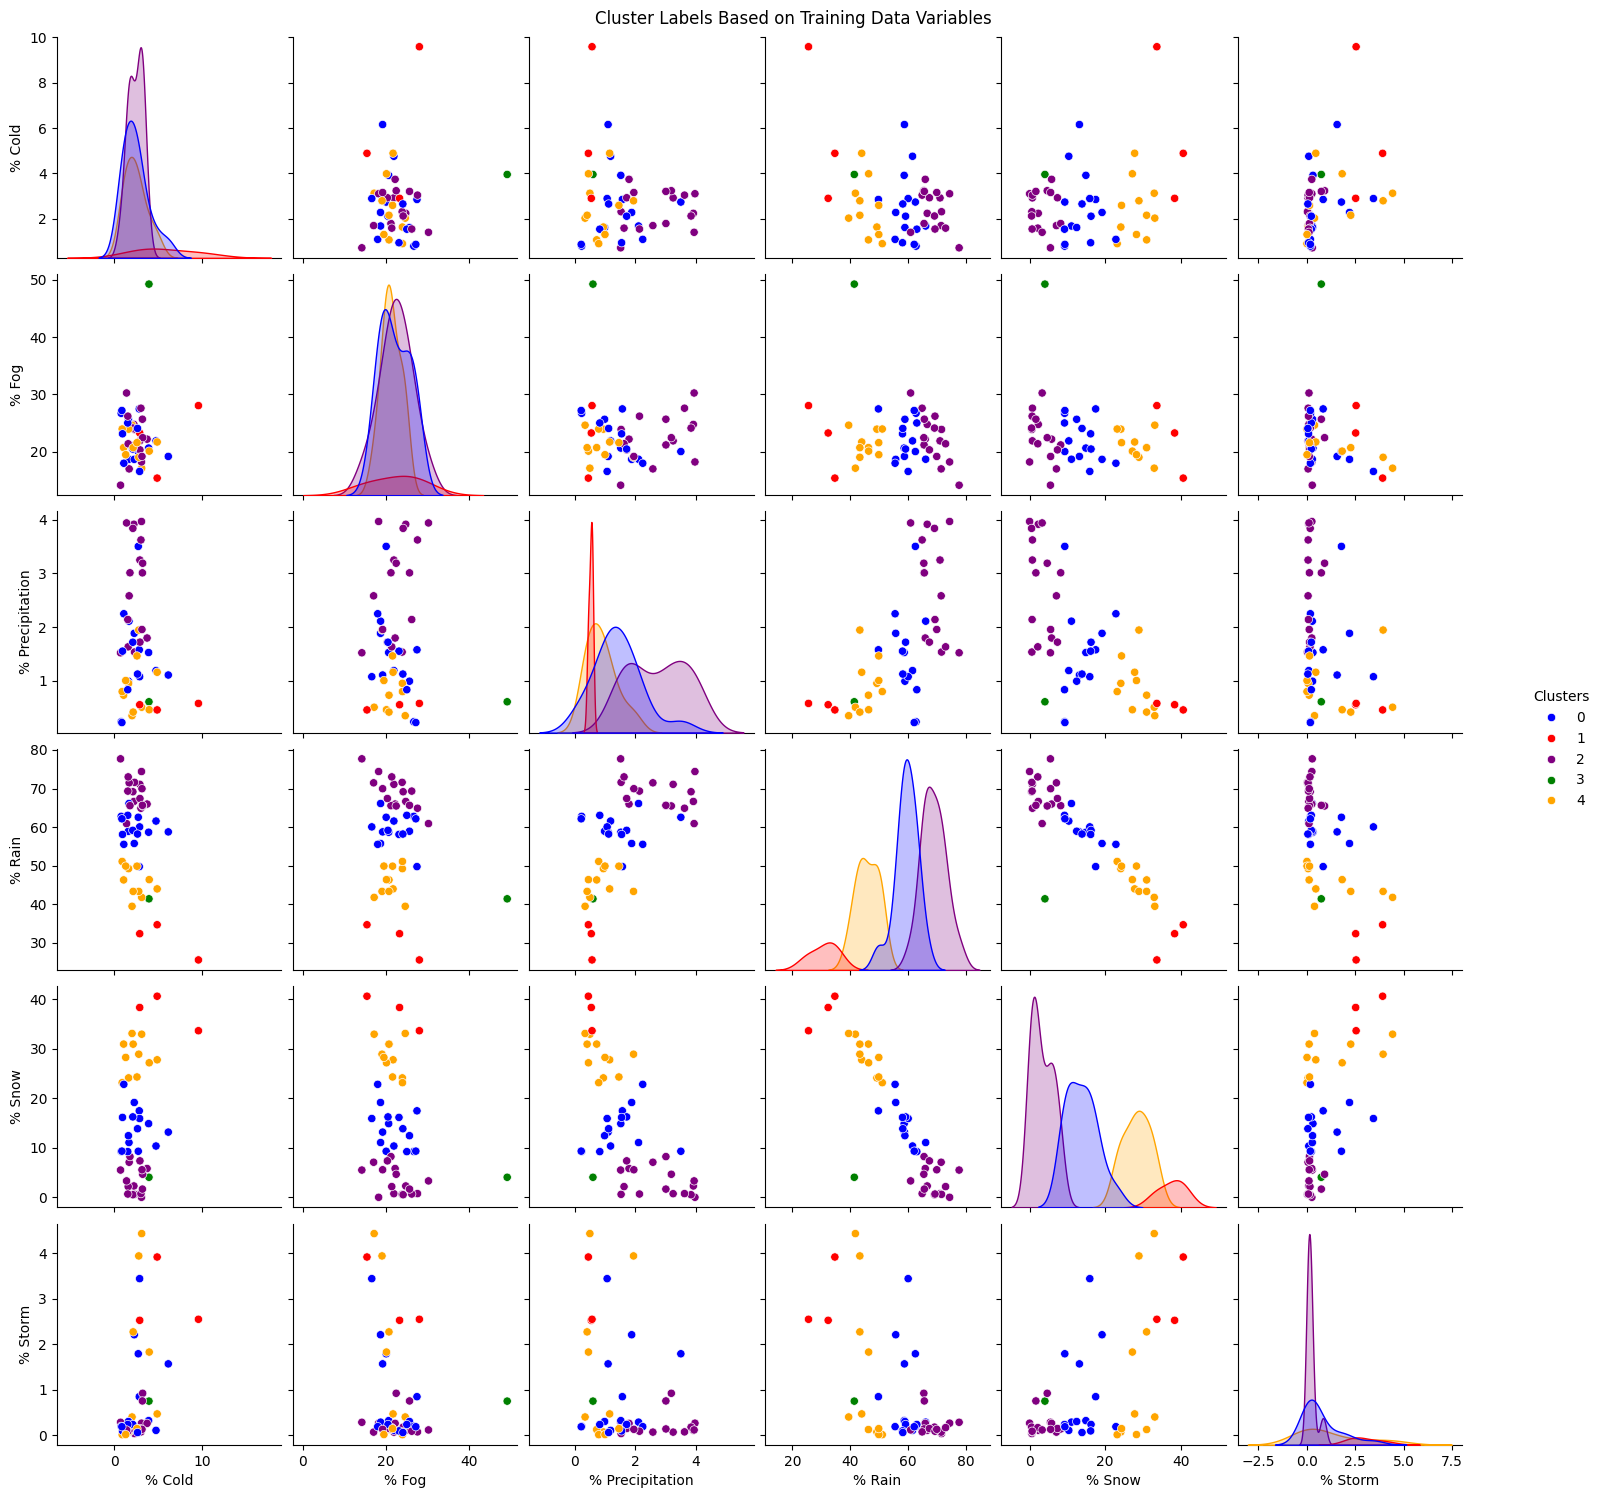

In [49]:
colors = {0: 'blue', 1: 'red', 2: 'purple', 3: 'green', 4: 'orange'}
plot = sns.pairplot(cluster_df, hue = 'Cluster_Labels', palette = colors)
plot._legend.set_title('Clusters')
plot.fig.suptitle('Cluster Labels Based on Training Data Variables', y = 1)
plt.show(plot)

The plot above shows us the clusters we've found relative to each of the features we used for the clustering analysis. We can clearly see that the single point in cluster 3 is far away from the rest of the points in several of the plots. We will treat this point as an outlier and consider what happens if we remove this point.

###Outlier Removal

We find that the outlier point represents California. We will remove this point from the data set.

In [51]:
# Remove outlier entry
cluster_df['State'] = weather_type_df['State']
weather_type_df = weather_type_df[weather_type_df['State'] != 'CA'].reset_index()
cluster_df = cluster_df[cluster_df['State'] != 'CA'].reset_index()
weather_type_df.drop(columns = ['index'], inplace = True)
cluster_df.drop(columns = ['index', 'State'], inplace = True)

###Round 2

Now we will run K-means again after the removal of the outlier point.

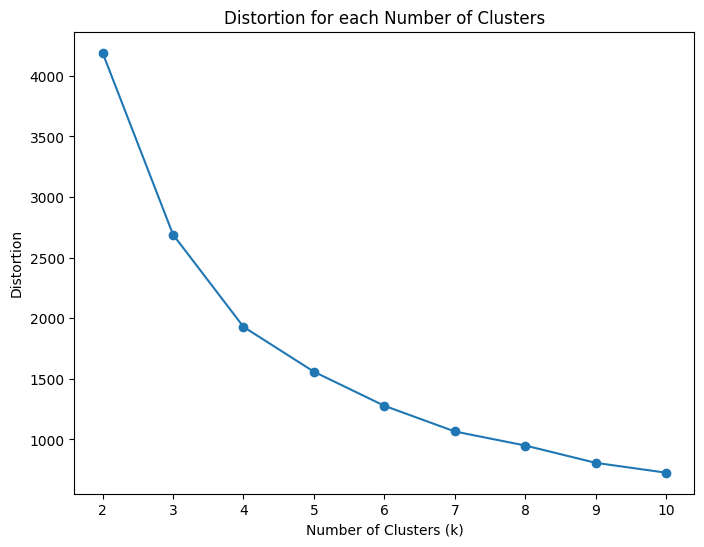

In [54]:
 # Run k-means again
distortions = []

max_k = 10
for i in range (2, max_k+1):
  km = KMeans(n_clusters = i, n_init = 5, random_state = 0, max_iter = 400)
  km.fit(cluster_df)
  distortions.append(km.inertia_)

fig = plt.subplots(figsize = (8,6))
plt.plot(range(2, max_k+1), distortions, marker = 'o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('Distortion for each Number of Clusters')
plt.show()

Using the elbow method, we can see that 4 is the ideal number of clusters.

In [55]:
km = KMeans(n_clusters = 4, n_init = 5, random_state = 0, max_iter = 400)
kmeans = km.fit(cluster_df)

In [56]:
# Get cluster labels
clusters = pd.DataFrame(kmeans.labels_, columns = ['Labels'])
clusters['Labels'].value_counts()

Labels
0    17
2    16
1    11
3     3
Name: count, dtype: int64

In [57]:
weather_type_df['Cluster_Labels'] = clusters['Labels']
cluster_df['Cluster_Labels'] = clusters['Labels']

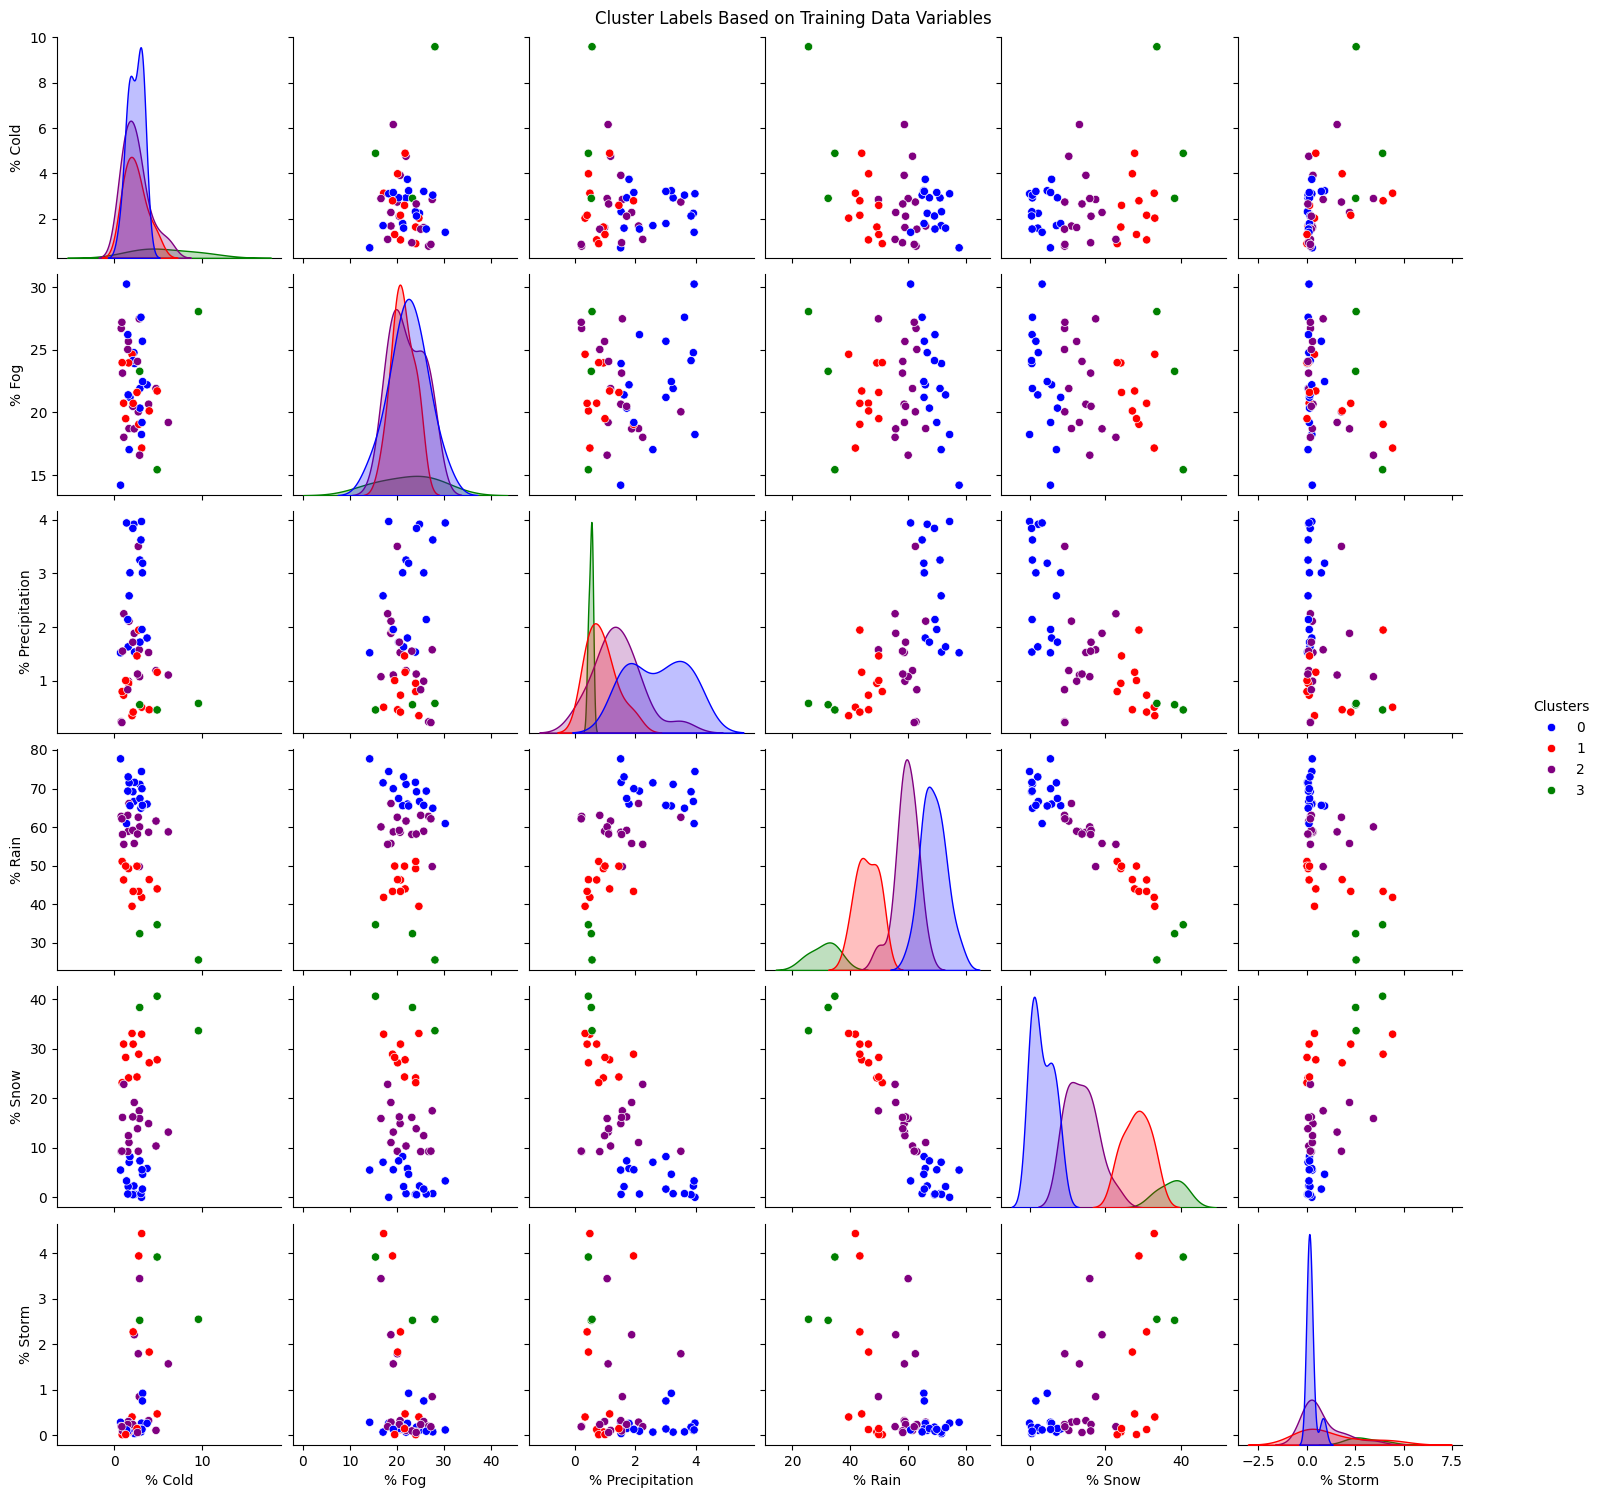

In [58]:
colors = {0: 'blue', 1: 'red', 2: 'purple', 3: 'green'}
plot = sns.pairplot(cluster_df, hue = 'Cluster_Labels', palette = colors)
plot._legend.set_title('Clusters')
plot.fig.suptitle('Cluster Labels Based on Training Data Variables', y = 1)
plt.show(plot)

This time, the pairplot above shows a more even distribution of points across the clusters with no visible outliers.

In order to visualize the clusters based on the locations of the states, we will use the latitude and longitude information provided in the data. Since each state may have multiple entries for latitude and longitude based on the number of airports/cities in the state, we will take the average of the latitude and longitude points.

In [59]:
lat_long_df = weather_df[['State', 'LocationLat', 'LocationLng']]
avg_lat_long_df = lat_long_df.groupby('State').mean().reset_index()
avg_lat_long_df = pd.merge(left = avg_lat_long_df, right = weather_type_df, how = 'right', left_on = 'State', right_on = 'State')
avg_lat_long_df.head()

,State,LocationLat,LocationLng,Cold,Fog,Hail,Precipitation,Rain,Snow,Storm,Total,% Cold,% Fog,% Precipitation,% Rain,% Snow,% Storm,Cluster_Labels
0,AL,32.708783,-86.682467,5530,41534,45,6163,134788,1433,131,189624,2.916298,21.903346,3.250116,71.081720,0.755706,0.069084,0
1,AR,35.140834,-92.533730,3552,39362,12,6226,105919,3683,173,158927,2.234988,24.767346,3.917522,66.646322,2.317416,0.108855,0
2,AZ,34.003798,-111.558857,3850,12008,21,691,36761,8253,980,62564,6.153699,19.193146,1.104469,58.757432,13.191292,1.566396,2
3,CO,39.089690,-105.701629,5728,31463,100,924,76664,60478,8119,183476,3.121934,17.148292,0.503608,41.784212,32.962349,4.425102,1
4,CT,41.492472,-72.731509,2350,10828,50,587,30439,5133,53,49440,4.753236,21.901294,1.187298,61.567557,10.382282,0.107201,2


The plot below shows the cluster labels based on the approximate latitude and longitude for each state.

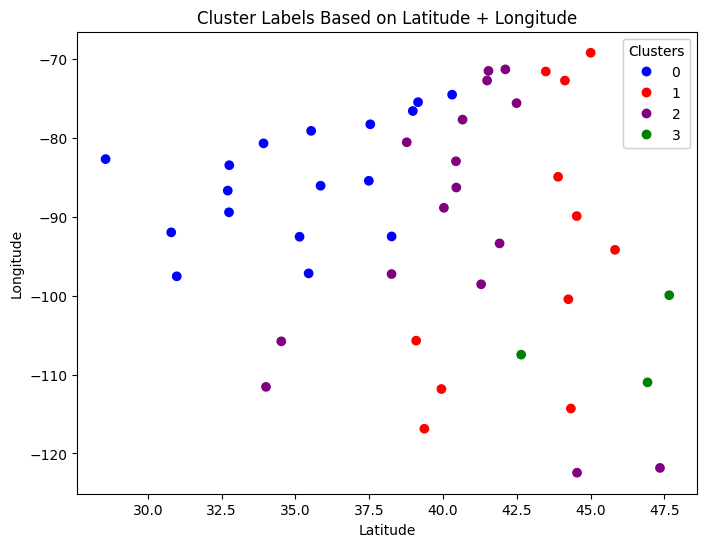

In [60]:
cmap = clr.ListedColormap(['blue', 'red', 'purple', 'green'])
fig, ax = plt.subplots(figsize = (8,6))
scatter = ax.scatter(x = avg_lat_long_df['LocationLat'], y = avg_lat_long_df['LocationLng'], c = avg_lat_long_df['Cluster_Labels'], cmap = cmap)
legend = ax.legend(*scatter.legend_elements(), title = 'Clusters')
ax.add_artist(legend)

plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Cluster Labels Based on Latitude + Longitude')
plt.show()